# Install Packages

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
## install required packages
!pip install swig
!pip install box2d
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

  Cloning https://github.com/AI4Finance-Foundation/FinRL.git to /tmp/pip-req-build-9_gg92ok
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/FinRL.git /tmp/pip-req-build-9_gg92ok
  Resolved https://github.com/AI4Finance-Foundation/FinRL.git to commit 453349afc2ee5eac8cc7f5766638c50f595df2d0
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-u1lucuda/elegantrl_8a9723a433ec4c4980b91837b874c4c1
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-install-u1lucuda/elegantrl_8a9723a433ec4c4980b91837b874c4c1
  Resolved https://github.com/AI4Finance-Foundation/ElegantRL.git to commit b4b9d662b9f9cb7cc368ac2b1036b5119eb20be4
  Preparing metadata (setup.py) ... done


In [3]:
import os
import itertools
import sys
#import time

import pandas as pd
import numpy as np
import datetime
import yfinance as yf
import matplotlib.pyplot as plt
%matplotlib inline

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.config import INDICATORS
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent, DRLEnsembleAgent
from stable_baselines3.common.logger import configure
from finrl import config_tickers
from finrl.main import check_and_make_directories
from finrl.config import INDICATORS, TRAINED_MODEL_DIR, RESULTS_DIR
from stable_baselines3 import A2C, DDPG, PPO, SAC, TD3
from finrl.config import INDICATORS
from finrl.config_tickers import DOW_30_TICKER

check_and_make_directories([TRAINED_MODEL_DIR])

/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/dtypes.py:35: DeprecationWarning: ml_dtypes.float8_e4m3b11 is deprecated. Use ml_dtypes.float8_e4m3b11fnuz
  from tensorflow.tsl.python.lib.core import pywrap_ml_dtypes


# Data Retrieve

In [4]:
TRAIN_START_DATE = '2010-11-10'
TRAIN_END_DATE = '2022-11-10'
TRADE_START_DATE = '2022-11-10'
TRADE_END_DATE = '2023-11-10'

In [5]:
df_dji = YahooDownloader(start_date = TRADE_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = ['^DJI']).fetch_data()

[*********************100%%**********************]  1 of 1 completed
Shape of DataFrame:  (251, 8)


In [6]:
df_aapl = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = ['AAPL']).fetch_data()

[*********************100%%**********************]  1 of 1 completed
Shape of DataFrame:  (3272, 8)


# Data Preprocessing


In [7]:
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_vix=True,
                     use_turbulence=True,
                     user_defined_feature = False)

processed = fe.preprocess_data(df_aapl)

Successfully added technical indicators
[*********************100%%**********************]  1 of 1 completed
Shape of DataFrame:  (3271, 8)
Successfully added vix
Successfully added turbulence index


In [8]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

### Split the data for training and trading

In [9]:
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))

3021
250


In [10]:
train

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2010-11-10,AAPL,11.308571,11.384643,11.198214,9.628129,384227200.0,2.0,0.000000,9.666325,9.548152,0.000000,-66.666667,100.000000,9.628129,9.628129,18.469999,0.000000
1,2010-11-11,AAPL,11.250000,11.371429,11.223214,9.586349,361284000.0,3.0,-0.000937,9.666325,9.548152,0.000000,-66.666667,100.000000,9.607239,9.607239,18.639999,0.000000
2,2010-11-12,AAPL,11.285714,11.303571,10.843929,9.325383,795846800.0,4.0,-0.009287,9.841417,9.185157,0.000000,-100.000000,100.000000,9.513287,9.513287,20.610001,0.000000
3,2010-11-15,AAPL,11.016429,11.090714,10.938214,9.295415,403606000.0,0.0,-0.013939,9.804141,9.113497,0.000000,-79.085709,100.000000,9.458819,9.458819,20.200001,0.000000
4,2010-11-16,AAPL,10.918571,10.985714,10.690000,9.130418,657650000.0,1.0,-0.022739,9.812321,8.973957,0.000000,-110.697931,100.000000,9.393139,9.393139,22.580000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3016,2022-11-03,AAPL,142.059998,142.800003,138.750000,137.879318,97918500.0,3.0,-0.490041,154.491970,133.364875,43.784867,-90.141063,20.980348,144.396027,152.450569,25.299999,3.945636
3017,2022-11-04,AAPL,142.089996,142.669998,134.380005,137.610825,140814800.0,4.0,-1.100306,154.579703,133.130163,43.651208,-108.444150,28.965228,144.004851,151.956150,24.549999,0.007411
3018,2022-11-07,AAPL,137.110001,139.149994,135.669998,138.147797,83374600.0,0.0,-1.523060,154.640798,132.943025,44.004851,-110.485615,28.965228,143.620322,151.410947,24.350000,0.034184
3019,2022-11-08,AAPL,140.410004,141.429993,137.490005,138.724594,89908500.0,1.0,-1.790908,154.598782,133.059641,44.392651,-80.326766,21.637302,143.222258,150.857322,25.540001,0.039003


# Environment

In [10]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 1, State Space: 11


In [16]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)

Training environment

In [17]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


# Train DRL agents

### PPO

In [45]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.005,
    "learning_rate": 0.0001,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

# set up logger
tmp_path = RESULTS_DIR + '/ppo'
new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
# Set new logger
model_ppo.set_logger(new_logger_ppo)

{'n_steps': 2048, 'ent_coef': 0.005, 'learning_rate': 0.0001, 'batch_size': 128}
Using cuda device
Logging to results/ppo


In [46]:
%time
trained_ppo = agent.train_model(model=model_ppo,
                             tb_log_name='ppo',
                             total_timesteps=100000)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs
------------------------------------
| time/              |             |
|    fps             | 332         |
|    iterations      | 1           |
|    time_elapsed    | 6           |
|    total_timesteps | 2048        |
| train/             |             |
|    reward          | 0.008001544 |
------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 339          |
|    iterations           | 2            |
|    time_elapsed         | 12           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0061317747 |
|    clip_fraction        | 0.0375       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.42        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0001       |
|    loss                 | 0.00608      |
|

8m14s

day: 3020, episode: 60
begin_total_asset: 1000000.00
end_total_asset: 8556224.61
total_reward: 7556224.61
total_cost: 8444.23
total_trades: 2992
Sharpe: 0.833

In [128]:
trained_ppo.save('trained_models' + "/agent_ppo_aapl")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### A2C

In [50]:
#A2C_PARAMS = {"n_steps": 5, "ent_coef": 0.005, "learning_rate": 0.0002}
#model_a2c = agent.get_model(model_name="a2c",model_kwargs = A2C_PARAMS)
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

# set up logger
tmp_path = RESULTS_DIR + '/a2c'
new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
# Set new logger
model_a2c.set_logger(new_logger_a2c)

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cuda device
Logging to results/a2c


In [51]:
trained_a2c = agent.train_model(model=model_a2c,
                                tb_log_name='a2c',
                                total_timesteps=100000)

-------------------------------------
| time/                 |           |
|    fps                | 365       |
|    iterations         | 100       |
|    time_elapsed       | 1         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -1.54     |
|    explained_variance | 1.19e-07  |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | -0.000833 |
|    reward             | 0.0       |
|    std                | 1.13      |
|    value_loss         | 5.25e-07  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 366      |
|    iterations         | 200      |
|    time_elapsed       | 2        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -1.62    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates        

10m21s

day: 3020, episode: 130
begin_total_asset: 1000000.00
end_total_asset: 6097947.90
total_reward: 5097947.90
total_cost: 13392.24
total_trades: 3018
Sharpe: 0.770

In [127]:
trained_a2c.save('trained_models' + "/agent_a2c_aapl")

### DDPG

In [18]:
agent = DRLAgent(env = env_train)
DDPG_PARAMS = {"batch_size": 32, "learning_rate": 0.0000000001}

model_ddpg = agent.get_model("ddpg", model_kwargs=DDPG_PARAMS)

tmp_path = RESULTS_DIR + '/ddpg'
new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
# Set new logger
model_ddpg.set_logger(new_logger_ddpg)

{'batch_size': 32, 'learning_rate': 1e-10}
Using cuda device
Logging to results/ddpg


In [19]:
trained_ddpg = agent.train_model(model=model_ddpg,
                             tb_log_name='ddpg',
                             total_timesteps=60000)

----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 160       |
|    time_elapsed    | 75        |
|    total_timesteps | 12084     |
| train/             |           |
|    actor_loss      | 1.83e+03  |
|    critic_loss     | 2.53e+03  |
|    learning_rate   | 1e-10     |
|    n_updates       | 9063      |
|    reward          | -33.01693 |
----------------------------------
----------------------------------
| time/              |           |
|    episodes        | 8         |
|    fps             | 142       |
|    time_elapsed    | 169       |
|    total_timesteps | 24168     |
| train/             |           |
|    actor_loss      | 1.78e+03  |
|    critic_loss     | 2.46e+03  |
|    learning_rate   | 1e-10     |
|    n_updates       | 21147     |
|    reward          | -33.01693 |
----------------------------------
day: 3020, episode: 10
begin_total_asset: 1000000.00
end_total_asset: 9617638.22
total_rew

6m35s

#### SAC

In [20]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 64,
    "buffer_size": 100000,
    "learning_rate": 0.0000001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

{'batch_size': 64, 'buffer_size': 100000, 'learning_rate': 1e-07, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cuda device


In [21]:


model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

# set up logger
tmp_path = RESULTS_DIR + '/sac'
new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])
# Set new logger
model_sac.set_logger(new_logger_sac)

{'batch_size': 64, 'buffer_size': 100000, 'learning_rate': 1e-07, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cuda device
Logging to results/sac


In [22]:
trained_sac = agent.train_model(model=model_sac,
                             tb_log_name='sac',
                             total_timesteps=50000)

-----------------------------------
| time/              |            |
|    episodes        | 4          |
|    fps             | 76         |
|    time_elapsed    | 158        |
|    total_timesteps | 12084      |
| train/             |            |
|    actor_loss      | 5.73e+03   |
|    critic_loss     | 6.09e+03   |
|    ent_coef        | 0.1        |
|    ent_coef_loss   | 71.9       |
|    learning_rate   | 1e-07      |
|    n_updates       | 11983      |
|    reward          | -31.483246 |
-----------------------------------
day: 3020, episode: 30
begin_total_asset: 1000000.00
end_total_asset: 9212684.65
total_reward: 8212684.65
total_cost: 15419.28
total_trades: 3020
Sharpe: 0.840
-----------------------------------
| time/              |            |
|    episodes        | 8          |
|    fps             | 76         |
|    time_elapsed    | 317        |
|    total_timesteps | 24168      |
| train/             |            |
|    actor_loss      | 3.39e+03   |
|    critic_

11m5s

# Backtesting

In [23]:
stock_dimension = len(trade.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 1, State Space: 11


In [24]:
trade

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2022-11-10,AAPL,141.240005,146.869995,139.500000,146.053619,118854000.0,3.0,-1.805133,155.154152,132.591368,49.339054,10.610887,4.314266,142.887598,149.775626,23.530001,16.939767
1,2022-11-11,AAPL,145.820007,150.009995,144.369995,148.867889,93979700.0,4.0,-1.135020,155.504463,133.389554,50.857681,66.663801,2.758485,143.276387,149.375171,22.520000,0.724929
2,2022-11-14,AAPL,148.970001,150.279999,147.429993,147.455780,73374100.0,0.0,-0.709714,155.787348,133.713857,50.078471,72.196539,3.360771,143.477460,148.994699,23.730000,0.192024
3,2022-11-15,AAPL,152.220001,153.589996,148.559998,149.205994,89868300.0,1.0,-0.228791,156.240861,133.909521,51.040267,99.098566,10.615700,143.616083,148.708755,24.540001,0.270937
4,2022-11-16,AAPL,149.130005,149.869995,147.289993,147.962936,64218300.0,2.0,0.051446,156.516185,134.148146,50.327862,62.724907,7.311494,143.703343,148.407720,24.110001,0.147789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,2023-11-02,AAPL,175.520004,177.779999,175.460007,177.336380,77334800.0,3.0,-1.131483,182.802070,166.690497,51.025495,63.709742,0.390528,174.084321,176.447541,15.660000,1.598714
246,2023-11-03,AAPL,174.240005,176.820007,173.350006,176.417572,79763700.0,4.0,-0.772380,182.713694,166.694982,50.133748,32.901525,8.153739,174.146240,176.429564,14.910000,0.142241
247,2023-11-06,AAPL,176.380005,179.429993,176.210007,178.994186,63841300.0,0.0,-0.276688,182.751869,166.680775,52.539942,89.398509,1.950536,174.251102,176.453533,14.890000,0.760682
248,2023-11-07,AAPL,179.179993,182.440002,178.970001,181.580780,70530000.0,1.0,0.321167,183.365620,166.409574,54.804687,136.219330,12.077039,174.579336,176.492814,14.810000,0.739328


In [25]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

In [26]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
env_trade, obs_trade = e_trade_gym.get_sb_env()

### Backtest agents

In [27]:
trained_a2c = A2C.load("/content/drive/MyDrive/RL_trading/trained_models" + "/agent_a2c_aapl")
trained_ppo = PPO.load("/content/drive/MyDrive/RL_trading/trained_models" + "/agent_ppo_aapl")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_ppo,
    environment = e_trade_gym)

hit end!


In [29]:
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_a2c,
    environment = e_trade_gym)

hit end!


In [30]:
df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
    model=trained_ddpg,
    environment = e_trade_gym)

hit end!


In [31]:
df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(
    model=trained_sac,
    environment = e_trade_gym)

hit end!


# Plotting

In [32]:
df_dji

,date,open,high,low,close,volume,tic,day
0,2022-11-10,33263.910156,33727.730469,33167.820312,33715.371094,480130000,^DJI,3
1,2022-11-11,33797.750000,33817.960938,33394.429688,33747.859375,427790000,^DJI,4
2,2022-11-14,33662.050781,33964.300781,33533.960938,33536.699219,354340000,^DJI,0
3,2022-11-15,33755.941406,33987.058594,33320.199219,33592.921875,390610000,^DJI,1
4,2022-11-16,33554.929688,33682.828125,33516.988281,33553.828125,301560000,^DJI,2
...,...,...,...,...,...,...,...,...
246,2023-11-03,33988.828125,34163.628906,33946.601562,34061.320312,311000000,^DJI,4
247,2023-11-06,34092.609375,34167.261719,33989.718750,34095.859375,265570000,^DJI,0
248,2023-11-07,34075.648438,34206.980469,34026.718750,34152.601562,281790000,^DJI,1
249,2023-11-08,34185.921875,34252.750000,33996.199219,34112.269531,280330000,^DJI,2


In [33]:
df_dji = df_dji[['date','close']]
fst_day = df_dji['close'][0]
dji = pd.merge(df_dji['date'], df_dji['close'].div(fst_day).mul(1000000),
               how='outer', left_index=True, right_index=True).set_index('date')
dji.rename(columns = {'account_value':'DJIA'}, inplace = True)
# dji

In [66]:
df_result_ppo = df_account_value_ppo.set_index(df_account_value_ppo.columns[0])
df_result_ppo.rename(columns = {'account_value':'ppo'}, inplace = True)

df_result_a2c = df_account_value_a2c.set_index(df_account_value_a2c.columns[0])
df_result_a2c.rename(columns = {'account_value':'a2c'}, inplace = True)

#df_result_ddpg = df_account_value_ddpg.set_index(df_account_value_ddpg.columns[0])
#df_result_ddpg.rename(columns = {'account_value':'ddpg'}, inplace = True)

result = pd.merge(result, df_result_ppo, how='outer', left_index=True, right_index=True)
result = pd.merge(result, df_result_a2c, how='outer', left_index=True, right_index=True)
#result = pd.merge(result, df_result_ddpg, how='outer', left_index=True, right_index=True)
#result = pd.merge(result, MVO_result, how='outer', left_index=True, right_index=True)
result = pd.merge(result, dji, how='outer', left_index=True, right_index=True).fillna(method='bfill')

In [34]:
df_result_a2c = (
    df_account_value_a2c.set_index(df_account_value_a2c.columns[0])
)
df_result_ddpg = (
    df_account_value_ddpg.set_index(df_account_value_ddpg.columns[0])
)
df_result_ppo = (
    df_account_value_ppo.set_index(df_account_value_ppo.columns[0])
)
df_result_sac = (
    df_account_value_sac.set_index(df_account_value_sac.columns[0])
)
result = pd.DataFrame(
    {
        "a2c": df_result_a2c["account_value"],
        "ddpg": df_result_ddpg["account_value"],
        "ppo": df_result_ppo["account_value"],
        "sac": df_result_sac["account_value"],
        "dji": dji["close"],
    }
)

In [37]:
result.to_csv('result_aapl.csv')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: xlabel='date'>

<Figure size 1500x500 with 0 Axes>

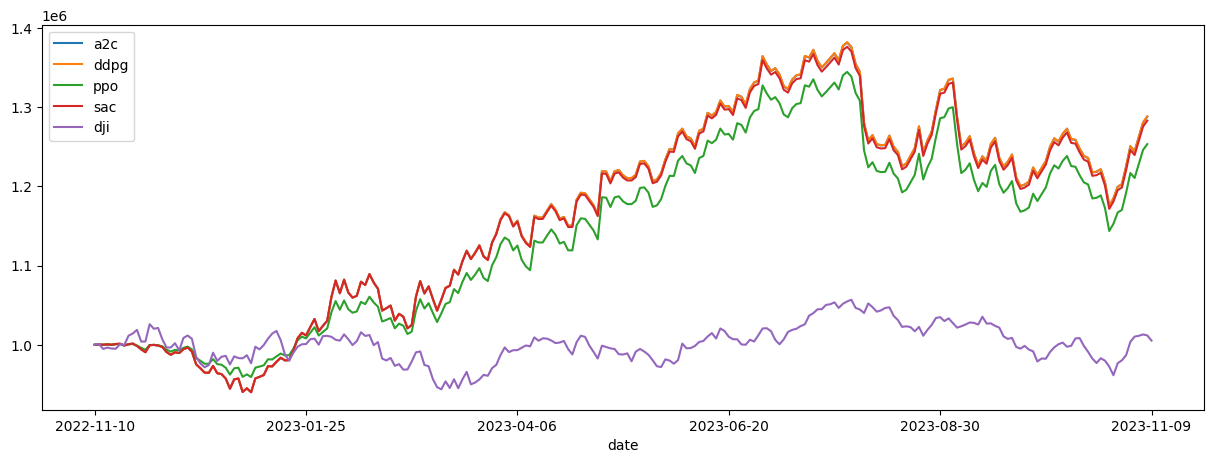

In [36]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure()
result.plot()

In [69]:
result

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,a2c,ddpg,ppo,dji
date,,,,
2022-11-10,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06
2022-11-11,1.000267e+06,1.000267e+06,1.000181e+06,1.000964e+06
2022-11-14,9.999695e+05,9.999695e+05,9.999793e+05,9.947006e+05
2022-11-15,1.000480e+06,1.000480e+06,1.000326e+06,9.963681e+05
2022-11-16,9.999677e+05,9.999677e+05,9.999780e+05,9.952086e+05
...,...,...,...,...
2023-11-03,1.244002e+06,1.244299e+06,1.210503e+06,1.010261e+06
2023-11-06,1.262169e+06,1.262472e+06,1.228181e+06,1.011285e+06
2023-11-07,1.280393e+06,1.280715e+06,1.245928e+06,1.012968e+06


<Figure size 1500x500 with 0 Axes>

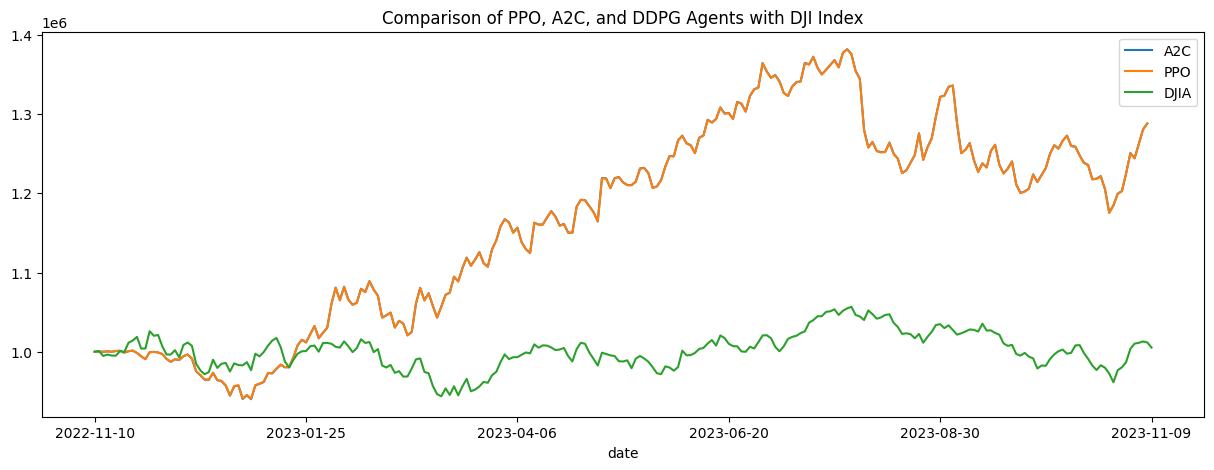

In [ ]:
plt.rcParams["figure.figsize"] = (15, 5)
plt.figure()
result.plot()
plt.title('Comparison of PPO, A2C, and DDPG Agents with DJI Index')
plt.show();

In [ ]:
result

,A2C,PPO,DJIA
date,,,
2022-11-10,1.000000e+06,1.000000e+06,1.000000e+06
2022-11-11,1.000267e+06,1.000264e+06,1.000964e+06
2022-11-14,9.999695e+05,9.999698e+05,9.947006e+05
2022-11-15,1.000480e+06,1.000475e+06,9.963681e+05
2022-11-16,9.999677e+05,9.999680e+05,9.952086e+05
...,...,...,...
2023-11-03,1.244299e+06,1.244043e+06,1.010261e+06
2023-11-06,1.262472e+06,1.262210e+06,1.011285e+06
2023-11-07,1.280715e+06,1.280448e+06,1.012968e+06


<Figure size 1500x500 with 0 Axes>

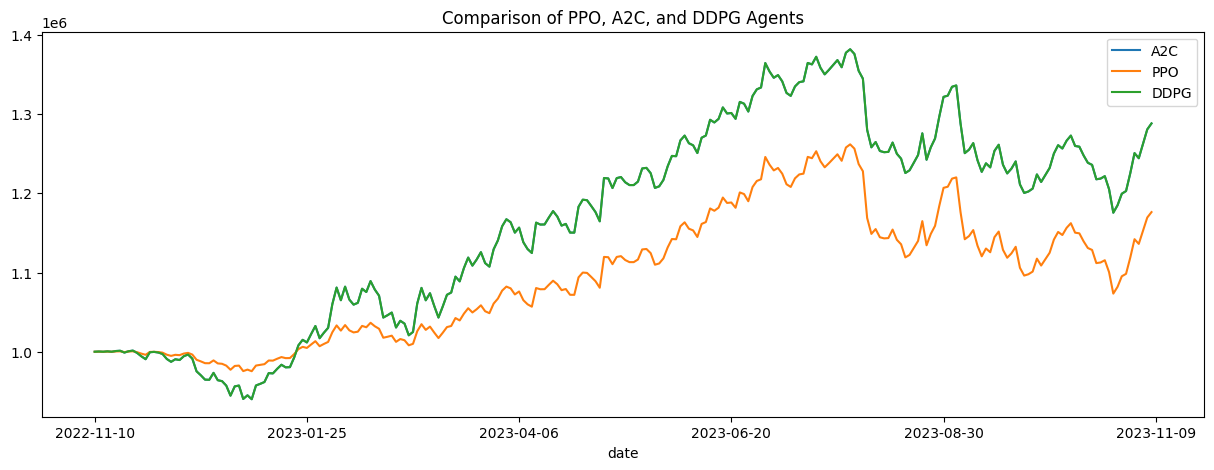

In [ ]:
agent = result[['A2C','PPO', 'DDPG']]
plt.rcParams["figure.figsize"] = (15, 5)
plt.figure()
agent.plot()
plt.title('Comparison of PPO, A2C, and DDPG Agents')
plt.show();

In [ ]:
result

,PPO,A2C,DDPG,DJIA
date,,,,
2022-11-10,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06
2022-11-11,1.000109e+06,1.000267e+06,1.000267e+06,1.000964e+06
2022-11-14,9.999875e+05,9.999695e+05,9.999695e+05,9.947006e+05
2022-11-15,1.000197e+06,1.000480e+06,1.000480e+06,9.963681e+05
2022-11-16,9.999868e+05,9.999677e+05,9.999677e+05,9.952086e+05
...,...,...,...,...
2023-11-03,1.136158e+06,1.244237e+06,1.244299e+06,1.010261e+06
2023-11-06,1.152751e+06,1.262407e+06,1.262472e+06,1.011285e+06
2023-11-07,1.169409e+06,1.280648e+06,1.280715e+06,1.012968e+06
